In [74]:
import random

import numpy as np
from fractions import Fraction
from numbers import Number


class TextBlock:
    def __init__(self, rows):
        assert isinstance(rows, list)
        self.rows = rows
        self.height = len(self.rows)
        self.width = max(map(len, self.rows))

    @classmethod
    def from_str(_cls, data):
        assert isinstance(data, str)
        return TextBlock(data.split('\n'))

    def format(self, width=None, height=None):
        if width is None: width = self.width
        if height is None: height = self.height
        return [f"{row:{width}}" for row in self.rows] + [' ' * width] * (height - self.height)

    @staticmethod
    def merge(blocks):
        return [" ".join(row) for row in zip(*blocks)]


class Matrix:
    """Общий предок для всех матриц."""

    @property
    def shape(self):
        raise NotImplementedError

    @property
    def dtype(self):
        raise NotImplementedError

    @property
    def width(self):
        return self.shape[1]

    @property
    def height(self):
        return self.shape[0]

    def __repr__(self):
        """Возвращает текстовое представление для матрицы."""
        text = [[TextBlock.from_str(f"{self[r, c]}") for c in range(self.width)] for r in range(self.height)]
        width_el = np.array(list(map(lambda row: list(map(lambda el: el.width, row)), text)))
        height_el = np.array(list(map(lambda row: list(map(lambda el: el.height, row)), text)))
        width_column = np.max(width_el, axis=0)
        width_total = np.sum(width_column)
        height_row = np.max(height_el, axis=1)
        result = []
        for r in range(self.height):
            lines = TextBlock.merge(
                text[r][c].format(width=width_column[c], height=height_row[r]) for c in range(self.width))
            for l in lines:
                result.append(f"| {l} |")
            if len(lines) > 0 and len(lines[0]) > 0 and lines[0][0] == '|' and r < self.height - 1:
                result.append(f'| {" " * (width_total + self.width)}|')
        return "\n".join(result)

    def empty_like(self, width=None, height=None):
        raise NotImplementedError

    def ident_like(self):
        raise NotImplementedError

    def __getitem__(self, key):
        raise NotImplementedError

    def __setitem__(self, key, value):
        raise NotImplementedError

    def __add__(self, other):
        if isinstance(other, Matrix):
            assert self.width == other.width and self.height == other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            matrix = self.empty_like()
            for r in range(self.height):
                for c in range(self.width):
                    matrix[r, c] = self[r, c] + other[r, c]
            return matrix
        return NotImplemented

    def __sub__(self, other):
        if isinstance(other, Matrix):
            assert self.width == other.width and self.height == other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            matrix = self.empty_like()
            for r in range(self.height):
                for c in range(self.width):
                    matrix[r, c] = self[r, c] - other[r, c]
            return matrix
        return NotImplemented

    def __mul__(self, other):
        return self.__matmul__(other)

    def __matmul__(self, other):
        # multiplication righthanded only (matrix*number)
        if isinstance(other, Matrix):
            assert self.width == other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            matrix = FullMatrix.zero(self.height, other.width, self[0, 0] - self[0, 0])
            for r in range(self.height):
                for c in range(other.width):
                    acc = None
                    for k in range(self.width):
                        add = self[r, k] * other[k, c]
                        acc = add if acc is None else acc + add
                    matrix[r, c] = acc
            return matrix
        elif isinstance(other, Number):
            matrix = self.zero(self.height, self.width, self[0, 0] - self[0, 0])
            for r in range(self.height):
                for c in range(self.width):
                    matrix[r, c] = self[r, c] * other
            return matrix
        return NotImplemented

    def __truediv__(self, other):
        if isinstance(other, Matrix):
            assert self.width == other.width and self.height == other.height, f"Shapes does not match: {self.shape} != {other.shape}"
            divider = self.inverse()
            matrix = self * divider
            return matrix
        return NotImplemented

    def inverse(self):
        l, u = self.lu()
        null = self[0, 0] - self[0, 0]
        l_inv = l.empty_like()
        u_inv = u.empty_like()
        for i in range(self.height):
            for j in range(self.width):
                if i == j:
                    u_inv[i, i] = u.invert_element(u[i, i])
                    l_inv[i, j] = l.invert_element(l[i, j])
                elif i > j:
                    u_inv[i, j] = null
                    temp = null
                    for k in range(i):
                        temp += l_inv[k, j] * l[i, k]
                    l_inv[i, j] = -l.invert_element(l[i, i]) * temp
                else:
                    l_inv[i, j] = null
                    temp = null
                    for k in range(j):
                        temp += u_inv[i, k] * u[k, j]
                    u_inv[i, j] = -u.invert_element(u[j, j]) * temp
        return u_inv * l_inv

    def invert_element(self, element):
        if isinstance(element, Number):
            return 1 / element
        if isinstance(element, Fraction):
            return 1 / element
        if isinstance(element, Matrix):
            return element.inverse()
        raise TypeError

    def lu(self):
        raise NotImplementedError

    def det(self):
        assert self.width == self.height, f"Matrix is not square: {self.height} != {self.width}"
        l, u = self.lu()
        det = 1
        for i in range(u.height):
            det *= u[i, i]
        return det

    def lup(self):
        temp = self
        p = self.zero(self.width, self.height, self[0, 0] - self[0, 0])
        for i in range(self.height):
            if self[i, i] != 0:
                p[i, i] = self[0, 0] / self[0, 0]
        for i in range(self.height):
            ref_val = 0
            ref_num = -1
            for j in range(i, self.width):
                if np.abs(temp[j, i]) >= ref_val:
                    ref_val = np.abs(temp[j, i])
                    ref_num = j
            if ref_val != 0:
                temp.swap_rows(ref_num, i)
                p.swap_rows(ref_num, i)
                for j in range(i + 1, self.height):
                    temp[j, i] /= temp[i, i]
                    for k in range(i + 1, self.height):
                        temp[j, k] -= temp[j, i] * temp[i, k]
        u = self.zero(self.width, self.height, self[0, 0] - self[0, 0])
        l = self.zero(self.width, self.height, self[0, 0] - self[0, 0])
        for i in range(self.height):
            for j in range(self.height):
                if i == j:
                    u[i, j] = temp[i, j]
                    l[i, j] = 1
                elif i < j:
                    u[i, j] = temp[i, j]
                    l[i, j] = 0
                else:
                    l[i, j] = temp[i, j]
                    u[i, j] = 0
        return temp, l, u, p

    def swap_rows(self, num1, num2):
        matrix = self
        temp = self.empty_like()
        for i in range(self.height):
            temp[num1, i] = self[num1, i]
            matrix[num1, i] = self[num2, i]
            matrix[num2, i] = temp[num1, i]
        return matrix

    def swap_cols(self, num1, num2):
        matrix = self
        temp = self.empty_like()
        for i in range(self.width):
            temp[i, num1] = self[i, num1]
            matrix[i, num1] = self[i, num2]
            matrix[i, num2] = temp[i, num1]
        return matrix

    def transpone(self):
        raise NotImplementedError

    def zero(self, width, height, param, low_bandw, upp_bandw):
        raise NotImplementedError

    def solve(self, vector):
        if isinstance(vector, Matrix):
            assert vector.width == 1 and self.width == vector.height and self.height == self.width, f"Vector or matrix shape is wrong: {self.shape}, {vector.shape}"
            garbage, l, u, p = self.lup()
            y_vec = vector.empty_like()
            pb = p * vector
            result = vector.empty_like()
            temp = 0
            flag = 0
            # solving Ly=Pb
            for i in range(self.height):
                y_vec[i, 0] = (pb[i, 0] - temp) / l[i, i]
                temp = 0
                flag += 1
                for j in range(i + 1):
                    if i < self.height - 1:
                        temp += l[i + 1, j] * y_vec[j, 0]
            # solving Ux=y
            temp = 0
            for i in range(self.height - 1, -1, -1):
                result[i, 0] = (y_vec[i, 0] - temp) / u[i, i]
                temp = 0
                for j in range(self.height - 1, i - 1, -1):
                    temp += u[i - 1, j] * result[j, 0]
            return result
        return NotImplemented


class FullMatrix(Matrix):
    """
    Заполненная матрица с элементами произвольного типа.
    """

    def __init__(self, data):
        """
        Создает объект, хранящий матрицу в виде np.ndarray `data`.
        """
        assert isinstance(data, np.ndarray)
        self.data = data

    def transpone(self):
        matrix = self.zero(self.width, self.height, self[0, 0] - self[0, 0])
        for i in range(self.width):
            for j in range(self.height):
                matrix[i, j] = self[j, i]
        return matrix

    def empty_like(self, width=None, height=None):
        dtype = self.data.dtype
        if width is None:
            width = self.data.shape[1]
        if height is None:
            height = self.data.shape[0]
        data = np.empty((height, width), dtype=dtype)
        return FullMatrix(data)

    def ident_like(self, width=None, height=None):
        dtype = self.data.dtype
        if width is None:
            width = self.data.shape[1]
        if height is None:
            height = self.data.shape[0]
        data = np.empty((height, width), dtype=dtype)
        for i in range(self.height):
            data[i, i] = self[i, i] * self.invert_element(self[i, i])
        return FullMatrix(data)

    def lu(self):
        assert self.width == self.height, f"Matrix is not square: {self.height} != {self.width}"
        u = self.zero(self.width, self.height, self[0, 0] - self[0, 0])
        l = self.zero(self.width, self.height, self[0, 0] - self[0, 0])
        for i in range(self.height):
            l[i, i] = self[0, 0] / self[0, 0]
        for i in range(self.height):
            for j in range(self.height):
                if i <= j:
                    temp = u[0, 0] - u[0, 0]
                    for k in range(i + 1):
                        temp = temp + l[i, k] * u[k, j]
                    u[i, j] = self[i, j] - temp
                else:
                    temp = u[0, 0] - u[0, 0]
                    for k in range(j + 1):
                        temp = temp + l[i, k] * u[k, j]
                    l[i, j] = (self[i, j] - temp) * u.invert_element(u[j, j])
        return l, u

    @classmethod
    def zero(_cls, height, width, default=0, low_bandw=0, upp_bandw=0):
        """
        Создает матрицу размера `width` x `height` со значениями по умолчанию `default`.
        """
        data = np.empty((height, width), dtype=type(default))
        data[:] = default
        return FullMatrix(data)

    @property
    def shape(self):
        return self.data.shape

    @property
    def dtype(self):
        return self.data.dtype

    def __getitem__(self, key):
        row, column = key
        return self.data[row, column]

    def __setitem__(self, key, value):
        row, column = key
        self.data[row, column] = value


class SymmetricMatrix(Matrix):
    """
    Симметричная матрица
    """

    def __init__(self, data):
        """
        Создает объект, хранящий матрицу в виде np.ndarray `data`.
        """
        assert isinstance(data, np.ndarray)
        self.data = data

    def empty_like(self, width=None, height=None):
        dtype = self.data.dtype
        if width is None:
            width = self.data.shape[1]
        if height is None:
            height = self.data.shape[0]
        data = np.empty((height, width), dtype=dtype)
        return SymmetricMatrix(data)

    def ident_like(self, width=None, height=None):
        data = self.empty_like()
        for i in range(self.height):
            data[i, i] = self[i, i] * self.invert_element(self[i, i])
            for j in range(self.height):
                if i != j:
                    data[i, j] = self[0, 0] - self[0, 0]
        return data

    def lu(self):
        # cholecky decomposition used for this (l i not more uni-left-triangle)
        matrix = FullMatrix.zero(self.width, self.height, self[0, 0] - self[0, 0])
        for i in range(self.height):
            for j in range(i + 1):
                temp = 0
                for k in range(j):
                    temp += matrix[i, k] * matrix[j, k]
                if i == j:
                    matrix[i, j] = np.sqrt(self[i, i] - temp)
                else:
                    matrix[i, j] = (self[i, j] - temp) * matrix.invert_element(matrix[j, j])
        l, u = FullMatrix.zero(self.width, self.height, self[0, 0] - self[0, 0]), FullMatrix.zero(self.width,
                                                                                                  self.height,
                                                                                                  self[0, 0] - self[
                                                                                                      0, 0])
        for i in range(self.height):
            for j in range(self.width):
                if j > i:
                    l[i, j] = 0
                    u[i, j] = matrix[i, j]
                elif j < i:
                    u[i, j] = 0
                    l[i, j] = matrix[i, j]
                else:
                    u[i, j] = matrix[i, j]
                    l[i, j] = matrix[i, j]
        return l, u

    @classmethod
    def zero(_cls, width, height, default=0, low_bandw=0, upp_bandw=0):
        """
        Создает матрицу размера `height` x `height` со значениями по умолчанию `default`.
        """
        data = np.empty((height, height), dtype=type(default))
        data[:] = default
        return SymmetricMatrix(data)

    @property
    def shape(self):
        return self.data.shape

    @property
    def dtype(self):
        return self.data.dtype

    def __getitem__(self, key):
        row, column = key
        return self.data[row, column]

    def __setitem__(self, key, value):
        row, column = key
        self.data[row, column] = value
        self.data[column, row] = value


class BandMatrix(Matrix):
    """
    Заполненная матрица с элементами произвольного типа.
    """

    def __init__(self, data, low_bandw, upp_bandw):
        """
        Создает объект, хранящий матрицу в виде np.ndarray `data`.
        """
        assert isinstance(data, np.ndarray)
        self.data = data
        self.lw_bw = low_bandw
        self.up_bw = upp_bandw

    def transpone(self):
        matrix = self.zero(self.width, self.height, self[0, 0] - self[0, 0])
        for i in range(self.width):
            for j in range(self.height):
                matrix[i, j] = self[j, i]
        return matrix

    @classmethod
    def zero(_cls, height, width, default=0, low_bandw=0, upp_bandw=0):
        """
        Создает матрицу размера `width` x `height` со значениями по умолчанию `default`.
        """
        data = np.empty((height, low_bandw + upp_bandw + 1), dtype=type(default))
        data[:] = default
        return BandMatrix(data, low_bandw, upp_bandw)

    @property
    def shape(self):
        real_shape = (self.data.shape[0], self.data.shape[0])
        return real_shape

    @property
    def dtype(self):
        return self.data.dtype

    @property
    def low_bandw(self):
        return self.lw_bw

    @property
    def upp_bandw(self):
        return self.up_bw

    def __getitem__(self, key):
        row, column = key
        if row < column - self.lw_bw or row > column + self.up_bw:
            return 0
        else:
            return self.data[row, self.upp_bandw + row - column - 1]

    def __setitem__(self, key, value):
        row, column = key
        self.data[row, self.upp_bandw + row - column - 1] = value

    def lu(self):
        assert self.width == self.height, f"Matrix is not square: {self.height} != {self.width}"
        u = self.zero(self.width, self.height, self[0, 0] - self[0, 0])
        l = self.zero(self.width, self.height, self[0, 0] - self[0, 0])
        for i in range(self.height):
            if self[i, i] != 0:
                l[i, i] = self[0, 0] / self[0, 0]
        for i in range(self.height):
            for j in range(self.height):
                if i <= j:
                    temp = u.zero(u.width, u.height, u[0, 0] - u[0, 0])
                    for k in range(i + 1):
                        temp[i, j] = temp[i, j] + l[i, k] * u[k, j]
                    u[i, j] = self[i, j] - temp[i, j]
                elif i > j:
                    temp = u.zero(u.width, u.height, u[0, 0] - u[0, 0])
                    for k in range(j + 1):
                        temp[i, j] = temp[i, j] + l[i, k] * u[k, j]
                    l[i, j] = (self[i, j] - temp[i, j]) * u.invert_element(u[j, j])
        return l, u

class ToeplitzMatrix(Matrix):
    """
    Матрица Тёплица.
    """
    def __init__(self, data):
        """
        Создает объект, хранящий матрицу в виде np.ndarray `data`.
        """
        assert isinstance(data, np.ndarray)
        self.data = data

    @property
    def width(self):
        return int((self.data.shape[0]+1)/2)

    @property
    def height(self):
        return int((self.data.shape[0]+1)/2)

    @property
    def shape(self):
        real_shape = (int((self.shape[0]+1)/2), int((self.shape[0]+1)/2))
        return real_shape

    @property
    def dtype(self):
        return self.data.dtype

    def __getitem__(self, key):
        row, column = key
        return self.data[row - column]

    def __setitem__(self, key, value):
        #a[i,j] = a.s[i-j(mod n)]
        row, column = key
        self.data[row - column] = value

    def empty_like(self, width=None, height=None):
        dtype = self.data.dtype
        if width is None:
            width = self.data.shape[1]
        if height is None:
            height = self.data.shape[0]
        data = np.empty((height, width), dtype=dtype)
        return ToeplitzMatrix(data)

    @classmethod
    def zero(_cls, height, width, default=0.0, low_bandw=0, upp_bandw=0):
        """
        Создает матрицу размера `width` x `height` со значениями по умолчанию `default`.
        """
        data = np.empty(height+width-1, dtype=type(default))
        data[:] = default
        return ToeplitzMatrix(data)

    def solve_levi(self, vector):
        assert vector.height == self.width, "Vector size does not conduct with matrix"+" v - "+str(vector.height)+" m - "+str(self.width)
        to = [0.0] * self.height
        back = [0.0] * self.height
        vec_res = [0.0] * self.height
        to[0] = [self.invert_element(self[0,0])]
        back[0] = [self.invert_element(self[0,0])]
        vec_res[0] = [vector[0,0] / self[0, 0]]

        for i in range(self.height-1):
            forw = to[i]
            backw = back[i]
            e_to = 0
            e_back = 0
            for j in range(i+1):
                e_to += self[i+1, j] * forw[j]
                e_back += self[0, j+1] * backw[j]
            det = 1 - e_to * e_back
            to[i+1] = 1 / det * np.concatenate((to[i], [0])) - e_to / det * np.concatenate(([0], back[i]))
            back[i+1] = to[i+1][::-1]

        for i in range(self.height-1):
            e_to = 0
            res_temp = vec_res[i]
            for j in range(i+1):
                e_to += self[i+1, j] * res_temp[j]
            vec_res[i+1] = np.concatenate([vec_res[i], [0]]) + (vector[i+1,0] - e_to) * back[i+1]
        len_res = len(vec_res)
        x_v = FullMatrix.zero(len_res,1,0.0)
        for i in range(len_res):
            x_v[i,0] = vec_res[self.height - 1][i]
        return x_v

numerical_error = 5e-8


def equal(a, b):
    if isinstance(a, Number) and isinstance(b, Number):
        if abs(a - b) < numerical_error:
            return True
        else:
            return False
    if isinstance(a, Fraction) and isinstance(b, Fraction):
        if abs(a - b) < numerical_error:
            return True
        else:
            return False
    if isinstance(a, Matrix) and isinstance(b, Matrix):
        if a.shape != b.shape:
            return False
        for i in range(a.height):
            for j in range(a.width):
                if not equal(a[i, j], b[i, j]):
                    return True
        return True
    raise TypeError

# Матрица Теплица и циркулянт.

Ранее мы решали уравнение Пуассона используя LU разложение для матрицы дискретизованного оператора Лапласа
(см. [эту лабораторную](lu.ipynb)).
Использование особенностей конкретной матрицы позволяет ускорять вычисления,
в прошлой лабораторной мы использовали представление в виде блочной [ленточной матрицы](https://en.wikipedia.org/wiki/Band_matrix).
Равенство нулю всех элементов ленточной матрицы, кроме нескольких диагоналей, 
позволяет значительно сократить объем вычислений,
и к счастью, дискретизация дифференциальных операторов дает именно ленточные матрицы.
Ширина "ленты" зависит от выбора дискретизации и ее порядка точности.
Обратная матрица к ленточной уже вообще говоря не является ленточной,
например, матрица резольвенты $(\Delta-\zeta)^{-1}$ не содержит нулевых элементов.
Матрицы резольвенты в нашем случае, однако, не является матрицей общего вида,
так как пространство в задаче было изотропным, а следовательно элементы матрицы 
зависели только от разницы индексов, т.е. все элементы одной диагонали совпадали.
Такого рода матрицы естественным образом возникают во многих физических задачах,
поэтому желательно иметь для них максимально быстрые методы счета.
В настоящей лабораторной мы изучим, как использовать свойство равенства всех элементов каждой диагонали друг-другу для ускорения вычислений.

В прошлой лабораторной мы учли обращение в ноль мноих элементов матрицы $A$, получающейся дискетизаций
оператора Лапласа $\Delta=\partial_x^2+\partial_y^2$ 
конечными разностями на равномерной решетке 
$x_k=\frac{k-N}{N}$, $y_n=\frac{n-N}{N}$:
$$A_{k,n;k',n'}=\begin{cases}
N^2,& |n-n'|+|k-k'|=1,\\
-4N^2, & n=n', k=k',\\
0,& \text{в остальных случаях}.
\end{cases}.$$
Мы, однако, не учли равенство всех элементов одной (блочной) диагонали,
а именно, все элементы матрицы $A$ можно задать в терминах одного вектора $a$:
$$A_{k,n;k',n'}=a_{k-k',n-n'}.$$
Другими словами, действие матрицы $A$ на произвольных вектор $x$ эквивалентно свертке 
векторов $x$ и $a$ (по двум индексам сразу):
$$(Ax)_{k,n}=\sum_{k',n'}A_{k,n;k'n'}x_{k',n'}
=\sum_{k',n'} a_{k-k',n-n'} x_{k',n'}
=(a* x)_{k,n}.$$
Матриц, которые имеют равные элементы на каждой из диагоналей, называются [матрицами Теплица](https://en.wikipedia.org/wiki/Toeplitz_matrix).
Элементы разных диагоналей вообще говоря не совпадают,
так что математический аппарат матриц Теплица можно использовать и в случае, 
когда все коэффициенты $a_{n,k}$ отличны.
Тем не менее, наличие дополнительных симметрий позволяет ускорить расчеты и облегчить
обоснование корректности метода и оценки ошибок.

Нашей задачей снова будет решение уравнения Пуассона 
$\Delta u(x,y)=f(x,y)$ на квадрате $(x,y)\in[-1,1]^{\times 2}$ с периодическими граничными условиями 
$$\begin{cases}
u(-1,y)=u(1,y),\;\partial_x u(-1,y)=\partial_x u(1,y),\\
u(x,-1)=u(x,1),\;\partial_y u(x,-1)=\partial_y u(x,1),
\end{cases}
$$
в дискретизованном виде $Au=f$, где вектора заданы на равномерной сетке:
$u_{kn}=u(x_k,y_n),\quad f_{kn}=f(x_k,y_n)$.
Для однозначного задания решения положим $u(-1,-1)=0$.
Решение системы с матрицей Теплица может быть проведено за время $O(N^2)$
[алгоритмом Левинсона](https://en.wikipedia.org/wiki/Levinson_recursion), 
против сложности $O(N^3)$ для матрицы общего вида.

## Задания

1. Убедитесь, что матрица $A$ является (1) блочной матрицей Теплица, (2) блочной ленточной матрицей, (3) симметрической
матрицей, (4) неположительно определенной матрицей. Какие алгоритмы можно использовать для специальных матриц такого вида?

2. Реализуйте алгоритм Левинсона для блочных матриц (можно воспользоваться классами для блочных матриц из прошлой лабораторной). Как можно усовершенствовать алгоритм для ленточных матриц и для симметрических матриц? Решите уравнение Пуассона решателем линейных систем с блочными ленточными симметрическими матрицами Теплица. В качестве правой части системы возьмите $f(x,y)=\cos \pi x\cos \pi y$. Оцените точность решения.
Оцените сложность полученного алгоритма по времени.

In [75]:
# entering the toeplitz matrix via classes is going with 1d numpy array
# only for symmetric toeplitz matrices (miscalc error occurs)
A1 = ToeplitzMatrix.zero(5,5,0.0,0,0)
A1[0,0] = 1.0
A1[1,0] = 2.0
A1[2,0] = 3.0
A1[3,0] = 4.0
A1[4,0] = 10.0
A1[0,1] = 2.0
A1[0,2] = 3.0
A1[0,3] = 4.0
A1[0,4] = 10.0
print(A1.height)
print(A1.data)
print(A1)
y = FullMatrix.zero(5,1,0.0)
y[0,0] = 8.0
y[1,0] = 7.0
y[2,0] = 6.0
y[3,0] = 5.0
y[4,0] = 4.0
print(y)

x = A1.solve_levi(y)
print(A1*x)

5
[ 1.  2.  3.  4. 10. 10.  4.  3.  2.]
| 1.0  2.0 3.0 4.0 10.0 |
| 2.0  1.0 2.0 3.0 4.0  |
| 3.0  2.0 1.0 2.0 3.0  |
| 4.0  3.0 2.0 1.0 2.0  |
| 10.0 4.0 3.0 2.0 1.0  |
| 8.0 |
| 7.0 |
| 6.0 |
| 5.0 |
| 4.0 |
| 8.000000000000002 |
| 6.999999999999999 |
| 6.000000000000001 |
| 4.999999999999998 |
| 3.999999999999999 |


Среди всех матриц Теплица выделяют матрицы, все строки которых можно получить циклическими перестановками одной строки.
Матрицы такого вида называют [матрицей циркулянта.](https://en.wikipedia.org/wiki/Circulant_matrix) 
Циркулянты естественно возникают при изучении периодических систем,
в частности, изучаемое уравнение Пауссона на квадрате, приводит к циркулянту.
Действие матрицы циркулятна на вектор записывается в виде свертки, 
как и для матрицы Теплица выше, но количество произвольных коэффициентов в случае циркулянта меньше:
$$
(Ax)_{k,n}=\sum_{k',n'}a_{k-k'\mathrm{mod} N,n-n'\mathrm{mod} N} x_{k',n'},
$$
Заметим, что матрица циркулянта с двумя побочными диагоналями не является ленточной матрицей, так как она содержит левый нижний и правый верхних углы, например, для матрицы $5\times 5$:
$$\begin{pmatrix}
\alpha&\beta&0&0&\gamma\\
\gamma&\alpha&\beta&0&0\\
0&\gamma&\alpha&\beta&0\\
0&0&\gamma&\alpha&\beta\\
\beta&0&0&\gamma&\alpha
\end{pmatrix}.$$
Наличие "углов" затрудняло использование решателя для ленточных матриц для уравнения Пуассона и треловало использования формулы [Шермана-Моррисона-Вудбери](https://en.wikipedia.org/wiki/Woodbury_matrix_identity).
В циркулянте "углы" возникают естественно и могут обсчитываться очень эффективно.

Матрица циркулянта может быть диагонализована с помощью дискретного преобразования Фурье,
задаваемого матрицей 
$$F_{n;n'}=\theta^{nn'},\quad \theta=e^{-i2\pi/N},$$
где $N$ - размерность пространства.
В случае матрицы $A$ преобразование Фурье нужно применить по обоим индексам:
$$(F\otimes F)A(F\otimes F)^*=\Lambda,$$
где $\otimes$ обозначает [тензорное произведение матриц](https://en.wikipedia.org/wiki/Kronecker_product),
а матрица $\Lambda$ диагональная и ее диагональ состоит из координат вектора $(F\otimes F)a$.
Этот факт другими словами записывается так: преобразование Фурье переводит свертку векторов в поэлементное перемножение их Фурье образов.

Диагонализация матрицы циркулянта может быть использована для решения системы $Au=f$.
В терминах Фурье образов уравнение принимает вид $\Lambda (F\otimes F)u = (F\otimes F)f$ с диагональной матрицей $\Lambda$,
а значит для решения системы достаточно поделить правую часть на диагонал матрицы $\Lambda$ поэлементно.
Следовательно, явная формула для решения системы с циркулянтом принимает вид:
$$
u=(F^*\otimes F^*)\Lambda^{-1}(F\otimes F)f.
$$
Чтобы алгоритм был практически полезен, нужно уметь быстро вычислять прямое и обратное преобразование Фурье.
К счастью, алгоритм [быстрого преобразования Фурье](https://en.wikipedia.org/wiki/Fast_Fourier_transform)
позволяет вычислить $Fx$ на $N$ мерном векторе $x$ за время $O(N\log N)$.
Так как двухмерное преобразование $F\otimes F$ можно вычислить последовательно применяя $F$ по одной переменной и по другой переменной, то сложность вычисления действия $F\otimes F$ на вектор также $O(N\log N)$,
где $N$ на этот раз равно числу координат вектора $x$.
Так как сложность вычисления $\Lambda^{-1}x$ равна $O(N)$,
итоговая сложность решения системы методом преобразования Фурье равна $O(N\log N)$,
что значительно лучше сложности решения системы общего вида $O(N^3)$ или решения системы с матрицей Теплица $O(N^2)$.
Известная диагонализация также полезная для решения других задач, таких как нахождение спектра, вычисления определителя и т.п.

In [76]:
import matplotlib.pyplot as plt

In [82]:
def laplace(n):
    mat = np.zeros((n, n, n, n), dtype=int)
    for i1 in range(n):
        for i2 in range(n):
            mat[i1, i2, i1, i2] = -4
            mat[i1, i2, (i1- 1 ) % n, i2] = -10
            mat[i1, i2, (i1 + 1) % n, i2] = 48
            mat[i1, i2, i1, (i2 - 1) % n] = -97
            mat[i1, i2, i1, (i2 + 1) % n] = 15
    mat_res = mat.reshape((pow(n, 2), pow(n, 2)))
    return mat, mat_res

def D(n):
    mat, mat_res = laplace(n)
    mat_toep = ToeplitzMatrix.zero(len(mat_res[0, :]),len(mat_res[0, :]),0.0)
    for i in range(len(mat_res[0, :])):
        mat_toep[0,i] = mat_res[0,i]
        mat_toep[i,0] = mat_res[0,i]
    return mat_toep, mat_res

def vectors(n):
    sample = np.linspace(-1, 1, n)
    x_v = np.ravel([[not_homogen_part(x, y) for x in sample] for y in sample])
    x_v -= np.sum(x_v.T)
    d = D(n)[0]
    mat_d = FullMatrix.zero(d.height,d.width,0.0)
    for i in range(d.height):
        for j in range(d.width):
            mat_d[i,j] = d[i,j]
    y_v = mat_d.data.dot(x_v.T)
    X = FullMatrix.zero(len(x_v),1,0.0)
    Y = FullMatrix.zero(len(x_v),1,0.0)
    for i in range(len(x_v)):
        X[i,0] = x_v[i]
        Y[i,0] = y_v[i]
    return X, Y, x_v, y_v

def not_homogen_part(x, y):
    return np.cos(np.pi * x) * np.cos(np.pi * y)

num_points = 30
matrix = D(num_points)[0]
x, y, x_v, y_v = vectors(num_points)
vec_result = matrix.solve_levi(y)

print("Numerical:")
print(vec_result)
print("Analytic:")
print(x)

Numerical:
| -1.0059399336114761e-11 |
| -0.023379444280195547   |
| -0.09242458032749983    |
| -0.20390693430865495    |
| -0.35261371522495377    |
| -0.5315915593363685     |
| -0.7324716615018435     |
| -0.9458610914233215     |
| -1.1617819965550593     |
| -1.3701381553206746     |
| -1.5611870653658662     |
| -1.7259954919429508     |
| -1.856857176175712      |
| -1.947653171211329      |
| -1.9941379571727091     |
| -1.9941379571686975     |
| -1.9476531712022012     |
| -1.8568571761719825     |
| -1.7259954919616773     |
| -1.5611870654033286     |
| -1.3701381553591085     |
| -1.1617819965559322     |
| -0.9458610913895911     |
| -0.7324716614500835     |
| -0.5315915593043261     |
| -0.352613715218598      |
| -0.20390693429632467    |
| -0.09242458035950432    |
| -0.023379444309953264   |
| 4.222307069255094e-12   |
| -0.023379444287654007   |
| -0.04621229016338969    |
| -0.11364318929366507    |
| -0.22251914778051785    |
| -0.3677492468015863     |
| -0.5425

In [85]:
def test_laplace():
    for n in range(1,50):
        matrix = D(n)[0]
        x, y, x_v, y_v = vectors(n)
        vec_result = matrix.solve_levi(y)
        for i in range(n):
            if np.abs(vec_result[i,0]-x_v[i])>numerical_error:
                print("x_num:")
                print(vec_result)
                print("x_anal:")
                print(x)
                print("Error occurred", n)
                print(vec_result[i,0], x_v[i])
                print(np.abs(vec_result[i,0]-x_v[i]))
                return -1
    return 0

test_laplace()

0

In [83]:
num_values = 30
'''
laplace_ = laplace.m.reshape((N, N, N, N))
F_laplace  = np.fft.ifft2(np.fft.fft2(laplace_, axes=[0, 1]), axes=[2, 3])
'''
x_analyt = [[not_homogen_part(x, y) for x in range(num_values)] for y in range(num_values)]
x_analyt -= np.sum(x_analyt)
x_analyt = np.ravel(x_analyt)
mat, mat_res = laplace(num_values)
F_laplace = np.fft.ifft2(np.fft.fft2(mat, axes=[0, 1]), axes=[2, 3])
#mat_res_data = FullMatrix.zero(mat_res.height,mat_res.width,0.0)
#for i in range(mat_res.height):
#    for j in range(mat_res.width):
#        mat_res_data[i,j] = mat_res[i,j]
y = mat_res.dot(x_analyt.T)
F_y = np.fft.fft2(y_v.reshape((num_values, num_values)))
diagonal = np.array([F_laplace.reshape((num_values**2, num_values**2))[i, i] for i in range(num_values**2)])
F_x = np.ravel(F_y) / diagonal
F_x[0] = 0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


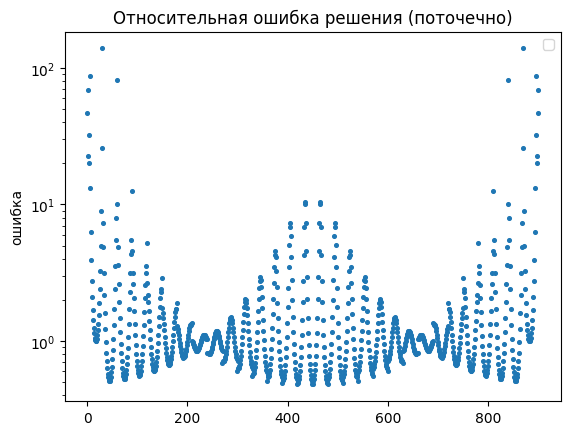

In [84]:
plt.scatter(range(num_values**2), np.abs((mat_res.dot(np.fft.ifft2((F_x.reshape((num_values, num_values)))).reshape((num_values**2,)).T) - y_v) / y_v), s = 7)
plt.yscale('log')
plt.title('Относительная ошибка решения (поточечно)')
plt.ylabel('ошибка')
plt.legend()

## Задания

3. Вычислите явным образом матрицу $\Lambda$ для заданного размера системы $N$. Используйте найденный явный вид матрицы $\Lambda$ для решения системы уравнения Пуассона методом Фурье по вышеприведенной формуле. Для вычисления преобразования Фурье используйте функции [`numpy.fft.fft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html) и `numpy.fft.ifft2`.

4. Как скорость вычисления быстрого преобразования Фурье зависит от размера вектора? Как оптимально выбрать размер системы? Нужно ли вычислять нормированное преобразование Фурье (аргумент norm функций `numpy.fft.fft2` и подобных), как он влияет на производительность?

5. Функция `numpy.fft.fft2` вычисляет преобразование Фурье на векторах с комплексными коэффициентами, но в нашей задаче
$\Lambda$ и $f$ вещественны, поэтому мы делаем в два раза больше работы, чем необходимо.
Попробуйте ускорить решатель, используя методы `numpy.fft.rfft2` и `numpy.fft.irfft2`.  
Какую схему хранения коэффициентов преобразования Фурье используют эти функции? 